In [1]:
#导入K-means，为后续准备
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import random
import pandas as pd
from sklearn.cluster import KMeans
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
def C_Kmeans(H,cluster_num):
    H=np.real(H)
    sp_kmeans = KMeans(n_clusters=cluster_num).fit(H)
    return sp_kmeans.labels_

d:\dl\envs\gluon\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
d:\dl\envs\gluon\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
d:\dl\envs\gluon\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
d:\dl\envs\gluon\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# 计算欧氏距离
def euclidDistance(x1, x2, sqrt_flag=False):
    res = np.sum((x1-x2)**2)
    if sqrt_flag:
        res = np.sqrt(res)
    return res

# 距离矩阵
def calEuclidDistanceMatrix(X):
    X = np.array(X)
    S = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            S[i][j] = 1.0 * euclidDistance(X[i], X[j])
            if (S[i][j]-0)<=0.0001:
                S[i][j]=0.1
            S[j][i] = S[i][j]
            
    return S


# 自调节谱聚类的邻接矩阵
def KNN_STSC(S, k):
    N = len(S)
    A = np.zeros((N,N))

    neighbours_id={}
    for i in range(N):
        neighbours_id[i] = np.argsort(S[i])[:k+1]
    for i in range(N):
        sigmai=np.sqrt(S[i][neighbours_id[i][k]])
        for j in range(N):
            sigmaj=np.sqrt(S[j][neighbours_id[j][k]])
            A[i][j] = np.exp(-S[i][j]/2/sigmai/sigmaj)
            A[j][i] = A[i][j] # mutually

        # 指定sigma的谱聚类

    return A

#固定sigma的谱聚类
def KNN_SC(S,k,sigma):
    N = len(S)
    A = np.zeros((N,N))
    for i in range(N):
        dist_with_index = zip(S[i], range(N))
        dist_with_index = sorted(dist_with_index, key=lambda x:x[0])
        neighbours_id = [dist_with_index[m][1] for m in range(k+1)] 
        for j in neighbours_id: 
            A[i][j] = np.exp(-S[i][j]/2/sigma/sigma)
            A[j][i] = A[i][j]
    return A

#构建标准化的拉普拉斯矩阵
def calLaplacianMatrix(adjacentMatrix):


    degreeMatrix = np.sum(adjacentMatrix, axis=1)


    laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix
    sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))
    return np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix)

#将拉普拉斯矩阵进行特征值分解
def getEigVec(L,cluster_num):
    eigval,eigvec=np.linalg.eig(L)
    dim=len(eigval)
    dictEigval=dict(zip(eigval,range(0,dim)))
    kEig=np.sort(eigval)[0:cluster_num]
    ix=[dictEigval[k] for k in kEig]
    return eigval[ix],eigvec[:,ix]

In [3]:
#普通谱聚类模型整
def SC(data,cluster_num,k,sigma):
    disMatrix=calEuclidDistanceMatrix(data)
    adjMatrix=KNN_SC(disMatrix,k,sigma)
    #print("adjmatrix")
    #print(adjMatrix)
    LaplacianMatrix=calLaplacianMatrix(adjMatrix)
    lam, H = getEigVec(LaplacianMatrix,cluster_num) # H'shape is n*n
    labels=C_Kmeans(H,cluster_num)
    #plt.scatter([x[0] for x in data],[x[1] for x in data],c=labels)
    return labels

#自调节谱聚类模型整
def STSC(data,cluster_num,k):
    disMatrix=calEuclidDistanceMatrix(data)
    adjMatrix=KNN_STSC(disMatrix,k)
    #print("adjmatrix")
    #print(adjMatrix)
    LaplacianMatrix=calLaplacianMatrix(adjMatrix)
    lam, H = getEigVec(LaplacianMatrix,cluster_num) # H'shape is n*n
    labels=C_Kmeans(H,cluster_num)
    #scatter(data(:,0),data(:,1),c=labels(:))
    plt.xlabel('X坐标')
    plt.ylabel('Y坐标')
    plt.scatter([x[0] for x in data],[x[1] for x in data],c=labels,label='同一类')
    plt.legend(loc=2,prop={'size':15})
    plt.title('聚类结果',fontsize=16)

    plt.savefig('filename.png',dpi=600)
    return labels


d:\dl\envs\gluon\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\dl\envs\gluon\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
d:\dl\envs\gluon\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\dl\envs\gluon\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


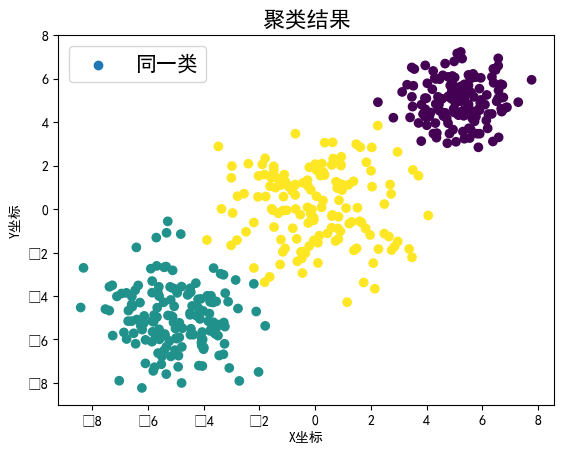

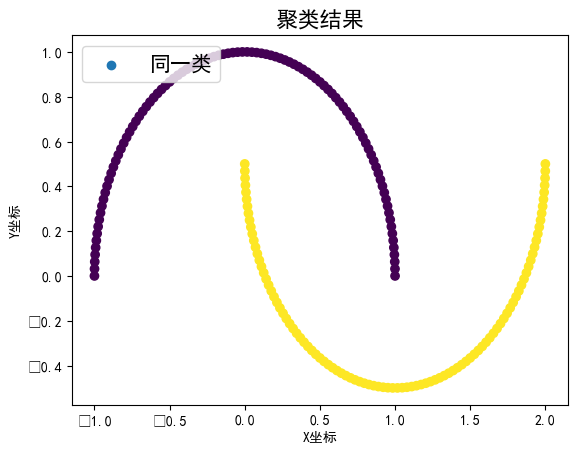

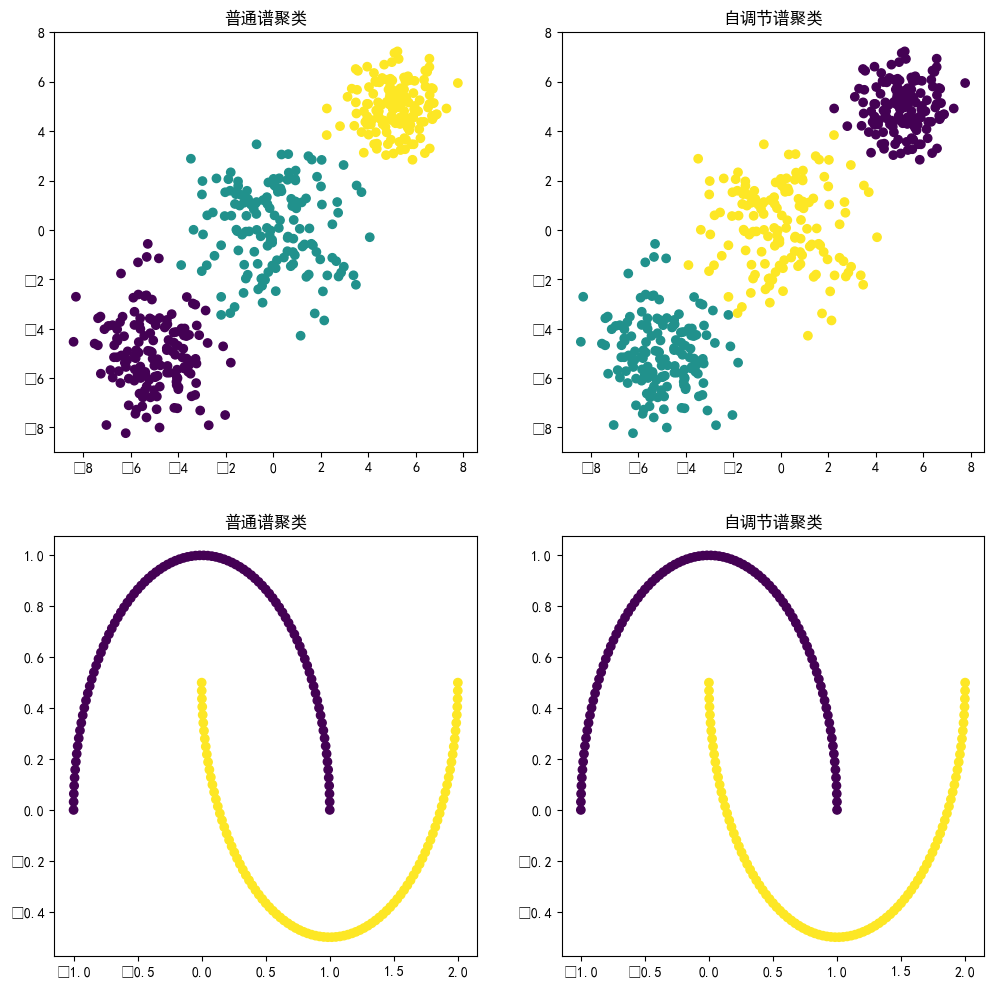

In [12]:
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

cluster_1 = (2**0.5)*np.random.randn(150,2)-[5,5]
cluster_2 = (3**0.5)*np.random.randn(150,2)
cluster_3 = np.random.randn(150,2)+[5,5]      
moon_dataset = datasets.make_moons(200)
moon_dataset_point = moon_dataset[0]

data_all = np.concatenate((np.concatenate((cluster_1,cluster_2)),cluster_3))     #将生成的三团正态分布数据整合
np.random.shuffle(data_all)       #打乱顺序

norm_label_SC = SC(data_all,3,4,2)
norm_label_STSC = STSC(data_all,3,4)
plt.figure()
moon_label_SC = SC(moon_dataset_point,2,4,2)
moon_label_STSC = STSC(moon_dataset_point,2,4)

fig , axes = plt.subplots(2,2,figsize=(12,12))

axes[0,0].scatter(data_all[:,0],data_all[:,1],c=norm_label_SC)
axes[0,0].set_title('普通谱聚类')
axes[0,1].scatter(data_all[:,0],data_all[:,1],c=norm_label_STSC)
axes[0,1].set_title('自调节谱聚类')
axes[1,0].scatter(moon_dataset_point[:,0],moon_dataset_point[:,1],c=moon_label_SC)
axes[1,0].set_title('普通谱聚类')
axes[1,1].scatter(moon_dataset_point[:,0],moon_dataset_point[:,1],c=moon_label_STSC)
axes[1,1].set_title('自调节谱聚类')
plt.show()

In [5]:
#计算纯度
import collections as clc
def purity(label_origin,label):
    count=0
    for i in np.unique(label):
        index_i=[j for j,x in enumerate(label) if x==i ]
        catch=[]
        for i in index_i:
            catch.append(label_origin[i])
        x=clc.Counter(catch).most_common()
        count+=x[0][1]
    #print('purity:','%.2f'%(count/len(label_origin)*100),'%')
    return '%.2f'%(count/len(label_origin)*100)+'%'

#DBI指数
def calDBI(data,label):
    # 计算每类的质心与Si
    centers={}
    S={}
    for i in np.unique(label):
#         print(i)
        index_i=[j for j,x in enumerate(label) if x==i ]
        vector=np.zeros((len(data[0])))
        for j in index_i:
            vector+=data[j]
        vector=vector/len(index_i)
        centers[i]=vector
        distance=0
        for j in index_i:
            distance+=euclidDistance(data[j],vector)
        S[i]=np.sqrt(distance/len(index_i))
#     print(centers)
#     print(S)
    # 计算Ri
    R=[]
    for i in np.unique(label):
        Ri_lst=[]
        for j in np.unique(label) :
            if j!=i:
#                 print("i:",i,"j:",j)
                M=euclidDistance(centers[i],centers[j],sqrt_flag=True)
                Sj=(S[i]+S[j])/M
                Ri_lst.append(Sj)
        Ri=max(Ri_lst)
        R.append(Ri)
    DBI=np.sum(R)/len(R)
#     print('DBI:',"%.2f"%(DBI*100)+'%')
    return '%.2f'%(DBI*100)

In [6]:
# 随机初始化隶属度矩阵
def initialize_U(samples,classes):
    #samples:样本数
    #classes:聚类中心数（类别数）
    u=np.random.rand(samples,classes)
    sumu=1/np.sum(u,axis=1)
    u=np.multiply(u.T,sumu)
    return u.T

# 计算样本到簇中心的距离（欧氏）
def distance(X,centroids):
    return np.sqrt(np.sum((X-centroids)**2,axis=1))

#更新隶属度矩阵
def computeU(X, centroids, m=2):
    sampleNumber = X.shape[0]  # 样本数
    classes = len(centroids)
    U = np.zeros((sampleNumber, classes))
    # 更新隶属度矩阵
    for i in range(classes):
        for k in range(classes):
            U[:, i] += (distance(X, centroids[i]) / distance(X, centroids[k])) ** (2 / (m - 1))
    U = 1 / U
 
    return U

#更新簇中心
def generateCentroid(centroids, data,U, m):
    
    sampleNumber = X.shape[0]
    centroidsNum=len(centroids)
    newCentroids=[]
    for j in range(centroidsNum):
        centroid = np.dot(U[:, i]**m, data) / (np.sum(U[:, i]**m))
        newCentroids.append(centroid)
    return newCentroids
 

def cluster(data, m, classes, EPS):
    """
    :param data: 数据集
    :param m: 模糊系数(fuzziness coefficient)
    :param classes: 类别数
    :return: 聚类中心矩阵,隶属度矩阵
    """
    sampleNumber = data.shape[0]  # 样本数
    cNumber = data.shape[1]       # 特征数
    U = initialize_U(sampleNumber, classes)   # 初始化隶属度矩阵
    U_old = np.zeros((sampleNumber, classes))
 
    while True:
        centroids = []
        # 更新簇中心
        for i in range(classes):
            centroid = np.dot(U[:, i]**m, data) / (np.sum(U[:, i]**m))
            centroids.append(centroid)
 
        U_old = U.copy()
        U = computeU(data, centroids, m)  # 计算新的隶属度矩阵
        if np.max(np.abs(U - U_old)) < EPS:
            return centroids,U
        
# 预测所属类别(划分)
def predict(X, centroids):
    labels = np.zeros(X.shape[0])
    U = computeU(X, centroids)  # 计算隶属度矩阵
    labels = np.argmax(U, axis=1)  # 找到隶属度矩阵中每行的最大值，即该样本最大可能所属类别
    return labels

#模型整合
def FCM(data,m,EPS,classes):
    centroids, U = cluster(data,  m, classes, EPS)
    labels = predict(data, centroids)
    #plt.scatter([x[0] for x in data],[x[1] for x in data],c=labels)
    return labels


In [7]:
# from sklearn import datasets
# import sklearn.datasets as sd

# import matplotlib.pyplot as plt
# digits=datasets.load_digits()
# iris=datasets.load_iris()
# moon_data,moon_label=sd.make_moons(n_samples=200)

# moon_label_FCM=FCM(moon_data,5,1e-8,2)
# moon_label_STSC=STSC(moon_data,2,5)
# moon_label_SC=SC(moon_data,2,5,1)
# iris_label_STSC=STSC(iris['data'].tolist(),3,4)
# iris_label_SC=SC(iris['data'].tolist(),3,4,2)
# iris_label_FCM=FCM(iris['data'],4,1e-9,3)
# digits_label_STSC=STSC(digits['data'].tolist(),9,4)
# digits_label_SC=SC(digits['data'].tolist(),9,4,2)
# digits_label_FCM=FCM(digits['data'],4,1e-9,9)


# purity_all={}

# purity_all['月亮数据模糊C']=purity(moon_label,moon_label_FCM)
# purity_all['月亮数据传统谱聚类']=purity(moon_label,moon_label_SC)
# purity_all['月亮数据自调节谱聚类']=purity(moon_label,moon_label_STSC)
# purity_all['digits数据模糊C']=purity(digits['target'],digits_label_FCM)
# purity_all['digits数据传统谱聚类']=purity(digits['target'],digits_label_SC)
# purity_all['digits数据自调节谱聚类']=purity(digits['target'],digits_label_STSC)
# purity_all['iris数据模糊C']=purity(iris['target'],iris_label_FCM)
# purity_all['iris数据传统谱聚类']=purity(iris['target'],iris_label_SC)
# purity_all['iris数据自调节谱聚类']=purity(iris['target'],iris_label_STSC)
# purity_all

In [8]:
# DBI_all={}
# DBI_all['月亮数据模糊C']=calDBI(moon_data,moon_label_FCM)
# DBI_all['月亮数据传统谱聚类']=calDBI(moon_data,moon_label_SC)
# DBI_all['月亮数据自调节谱聚类']=calDBI(moon_data,moon_label_STSC)
# DBI_all['digits数据模糊C']=calDBI(digits['data'],digits_label_FCM)
# DBI_all['digits数据传统谱聚类']=calDBI(digits['data'],digits_label_SC)
# DBI_all['digits数据自调节谱聚类']=calDBI(digits['data'],digits_label_STSC)
# DBI_all['iris数据模糊C']=calDBI(iris['data'],iris_label_FCM)
# DBI_all['iris数据传统谱聚类']=calDBI(iris['data'],iris_label_SC)
# DBI_all['iris数据自调节谱聚类']=calDBI(iris['data'],iris_label_STSC)
# DBI_all

In [9]:
# import pandas as pd
# dataframe={'DBI':DBI_all.values(),'Purity':purity_all.values()}
# pd.DataFrame(dataframe,index=DBI_all.keys())

In [10]:
from pandas import DataFrame as df
data=pd.read_excel('data.xlsx')
data
x=list(data.loc[:,'X坐标'])
y=list(data.loc[:,'Y坐标'])
cluster=[]
for i in range(1,len(x)):
    cluster.append([x[i],y[i]])
labels=STSC(cluster,12,5)
 
#写
dic1 = {'X坐标': x[1:],
        'Y坐标': y[1:],
        'labels':labels
}
df = df(dic1)
df.to_excel('cluster_result.xlsx', index=False)

d:\dl\envs\gluon\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\dl\envs\gluon\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
